In [2]:

import matplotlib.pyplot as plt
import numpy as np
import itertools as it
from math import pi
     

from qutip import *
from scipy import *
from scipy import sparse

In [20]:
def Jij_instance(N, seed):
    """Generates an random instance of couplings - bimodal - even ferro and anti-ferro"""

    np.random.seed(seed)

    num_of_bonds = (N * (N - 1)) // 2
    if N % 4 == 0:
        a1 = [-1 for i in range(num_of_bonds // 2)]
    else:
        a1 = [-1 for i in range((num_of_bonds // 2) + 1)]
    a2 = [1 for i in range(num_of_bonds // 2)]
    a = list(np.random.permutation(a1 + a2))
    Jij = [a[(N * j) : N * (j + 1)] for j in range(N // 2)]
    if N % 2 == 0:
        Jij[(N // 2) - 1] += Jij[(N // 2) - 1]
    Jij = np.array(Jij)
    return Jij

def JZZ_SK_ME(N,J):
    """ Computes matrix elements for the SK interactions
        and returns each as a 1D np.array
        --JZZ = sum_{i,j} J_{ij}sigma^z_i sigma^z_j"""
    

    JZZ = np.zeros(2**N)
    shift_state = np.zeros(N,dtype=int)
    for b in range(2**N):
        state = 2*np.array(list(bin(b)[2:].zfill(N))).astype(int) - 1
        for shift in range(1,N//2+1):
            shift_state[shift:] = state[:-shift]
            shift_state[:shift] = state[-shift:]
            if (N%2 == 0) and (shift == N//2):
                JZZ[b] = JZZ[b] + 0.5*np.dot(J[shift-1,:]*shift_state,state)
            else:
                JZZ[b] = JZZ[b] + np.dot(J[shift-1,:]*shift_state,state)

    return JZZ

def JZZ_SK(N,J):
    """Builds matrices for infinite range zz interactions
        and returns each as a scipy.sparse.coo_matrix
        --JZZ = sum_{i,j} J_{ij}sigma^z_i sigma^z_j"""
    JZZ_ME = JZZ_SK_ME(N,J)
    I = np.arange(2**N)
    return sparse.coo_matrix((JZZ_ME,(I,I)),shape=(2**N,2**N))

def hamming_distance(i,j,N):
    arr_i = np.array([int(s) for s in bin(i)[2:].zfill(N)])
    arr_j = np.array([int(s) for s in bin(j)[2:].zfill(N)])
    return int(np.sum(arr_i != arr_j))

def max_hamming_distance(gs, N):
    indeces = ()
    max_h_d = 0
    overlap_dist = []
    for i in range(len(gs)):
        for j in range(i+1,len(gs)):
            h_d = hamming_distance(gs[i],gs[j],N)
            overlap_dist.append((N-2*h_d)/N)
            if h_d > max_h_d:
                max_h_d = h_d
                indeces = (i,j)
    
    return [indeces,max_h_d,overlap_dist]

[[-1 -1 -1  1  1  1  1  1]
 [ 1 -1 -1 -1 -1 -1  1  1]
 [-1  1 -1 -1 -1 -1  1  1]
 [-1  1  1  1 -1  1  1  1]]
Ground states:
[ 63  95 160 192]
['00111111', '01011111', '10100000', '11000000']
Maximum Hamming distance:
(0, 1)
2


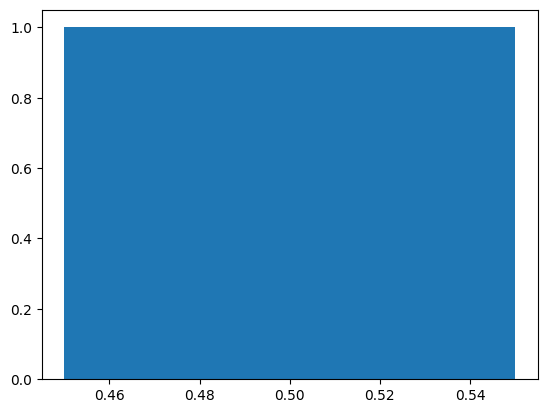

In [38]:
N = 8
seed = 17

Jij = Jij_instance(N,seed)
print(Jij)
JZZ = JZZ_SK(N, Jij)
true_gs = np.where(JZZ.diagonal() == JZZ.diagonal().max())[0]
print("Ground states:")
# true_gs = [3, 12, 19, 24, 26, 27, 28, 33, 35, 37, 44, 45, 82, 83, 90, 92, 94, 99, 100, 101, 103, 108, 115, 124, 131, 140, 147, 152, 154, 155, 156, 161, 163, 165, 172, 173, 210, 211, 218, 220, 222, 227, 228, 229, 231, 236, 243, 252]
print(true_gs)

print([ "".join([bin(g)[2:].zfill(N)]) for g in true_gs])

gs_size = len(true_gs)
reduced_gs = true_gs[:gs_size//2]
print("Maximum Hamming distance:")
indeces, max_h_d, overlap_dist = max_hamming_distance(reduced_gs,N)
print(indeces)
print(max_h_d)

bin_width = 0.1
shift_amount = bin_width/2
left_edge = np.min(overlap_dist) - shift_amount
right_edge = np.max(overlap_dist) + shift_amount

plt.hist(overlap_dist,bins=np.arange(left_edge, right_edge + bin_width, bin_width))
plt.show()




fair_sampling_gs = np.zeros([2**N,1])
gs_size = len(reduced_gs)



for g in reduced_gs:
    fair_sampling_gs[g] = 1/np.sqrt(gs_size)


fair_sampling_gs = Qobj(fair_sampling_gs, dims = [[2 for i in range(N)], [1 for i in range(N)]])


entropy_vals = []
entropy_vals.append(
    [
        [bp,round(entropy_vn(fair_sampling_gs.ptrace(list(bp))),6)]
        for bp in list(it.combinations(range(N), int(np.ceil(N/2))))
    ]
)

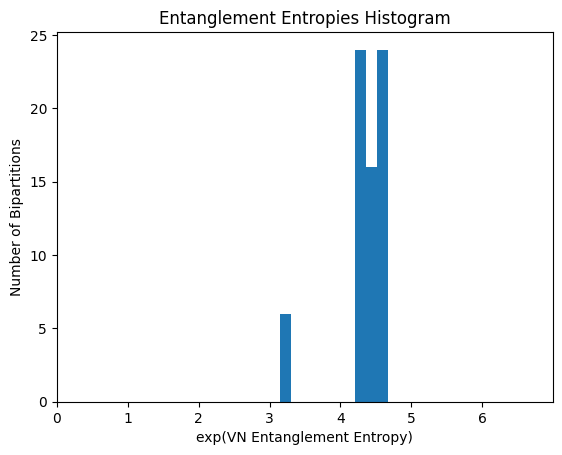

[3.149, 4.665, 4.665, 4.654, 4.654, 4.654, 4.654, 4.665, 4.665, 4.654, 4.665, 3.149, 3.149, 4.665, 4.654, 4.25, 4.25, 4.25, 4.25, 4.478, 4.478, 4.25, 4.25, 4.478, 4.438, 4.438, 4.478, 4.25, 4.25, 4.478, 4.478, 4.25, 4.25, 4.25, 4.25, 4.25, 4.25, 4.25, 4.25, 4.478, 4.478, 4.25, 4.25, 4.478, 4.438, 4.438, 4.478, 4.25, 4.25, 4.478, 4.478, 4.25, 4.25, 4.25, 4.25, 4.654, 4.665, 3.149, 3.149, 4.665, 4.654, 4.665, 4.665, 4.654, 4.654, 4.654, 4.654, 4.665, 4.665, 3.149]


In [32]:

# Pull raw entanglement entropy values out of results. Round to 3 decimal places so that hist bins aren't over precise
ee_vals = [round(np.e ** bp_e[1],3) for bp_e in entropy_vals[0]]

plt.hist(ee_vals)
plt.xlim(0,max(ee_vals)*1.5)

plt.title('Entanglement Entropies Histogram')
plt.ylabel('Number of Bipartitions')
plt.xlabel("exp(VN Entanglement Entropy)")
plt.show()
print(ee_vals)

In [33]:
# Calculate disconnectivity


out_obj  = {}
min_delta_m = 100
min_delta_m_info = []

ent_cache = {}

for bp_size in range(2,N + 1):
    out_obj[bp_size] = []


    

    for bp in list(it.combinations(range(N), bp_size)):
        bp_obj = {}

        bp_obj["bp"] = list(bp)

        bp_obj["s_m"] = round(entropy_vn(fair_sampling_gs.ptrace(list(bp))),5)
        ent_cache[bp] = bp_obj["s_m"]
        
        min_sub_m_ent = 100000
        min_sub_m_bp = []
        for s_bp_size in range(1,bp_size):
            for sbp in list(it.combinations(list(bp), s_bp_size)):
                if sbp in ent_cache:
                    sub_m_ent = round(2*ent_cache[sbp],5)
                else:
                    sub_m_ent = round(2*entropy_vn(fair_sampling_gs.ptrace(list(sbp))),5)
                if sub_m_ent < min_sub_m_ent:
                    min_sub_m_ent = sub_m_ent
                    min_sub_m_bp = list(sbp)

        bp_obj["min_sub_bp"] = min_sub_m_bp
        bp_obj["min_sub_s"] = min_sub_m_ent
        
        delta_m = bp_obj["s_m"]/bp_obj["min_sub_s"] if bp_obj["min_sub_s"] != 0 else 1
            

        
        bp_obj["delta_m"] = delta_m

        if delta_m < min_delta_m:
            min_delta_m = delta_m
            min_delta_m_info = [bp_obj]
        elif delta_m == min_delta_m:
            min_delta_m_info.append(bp_obj)

        out_obj[bp_size].append(bp_obj)


out_obj


{2: [{'bp': [0, 1],
   's_m': 0.56234,
   'min_sub_bp': [0],
   'min_sub_s': 0.0,
   'delta_m': 1},
  {'bp': [0, 2],
   's_m': 0.63651,
   'min_sub_bp': [0],
   'min_sub_s': 0.0,
   'delta_m': 1},
  {'bp': [0, 3],
   's_m': 0.63651,
   'min_sub_bp': [0],
   'min_sub_s': 0.0,
   'delta_m': 1},
  {'bp': [0, 4],
   's_m': 0.63651,
   'min_sub_bp': [0],
   'min_sub_s': 0.0,
   'delta_m': 1},
  {'bp': [0, 5],
   's_m': 0.63651,
   'min_sub_bp': [0],
   'min_sub_s': 0.0,
   'delta_m': 1},
  {'bp': [0, 6],
   's_m': 0.63651,
   'min_sub_bp': [0],
   'min_sub_s': 0.0,
   'delta_m': 1},
  {'bp': [0, 7],
   's_m': 0.63651,
   'min_sub_bp': [0],
   'min_sub_s': 0.0,
   'delta_m': 1},
  {'bp': [1, 2],
   's_m': 1.11083,
   'min_sub_bp': [1],
   'min_sub_s': 1.12467,
   'delta_m': 0.9876941680670774},
  {'bp': [1, 3],
   's_m': 1.11083,
   'min_sub_bp': [1],
   'min_sub_s': 1.12467,
   'delta_m': 0.9876941680670774},
  {'bp': [1, 4],
   's_m': 1.11083,
   'min_sub_bp': [1],
   'min_sub_s': 1.12467,

In [34]:
min_delta_m_info

[{'bp': [1, 2, 3, 4, 5, 6, 7],
  's_m': 0.0,
  'min_sub_bp': [1],
  'min_sub_s': 1.12467,
  'delta_m': 0.0}]

In [48]:
i = 9
j = 30
N = 8

arr_i = np.array([int(s) for s in bin(i)[2:].zfill(N)])
arr_j = np.array([int(s) for s in bin(j)[2:].zfill(N)])
int(np.sum(arr_i != arr_j))

4

In [62]:

for seed in range(100):
    N = 8

    Jij = Jij_instance(N,seed)
    JZZ = JZZ_SK(N, Jij)
    true_gs = np.where(JZZ.diagonal() == JZZ.diagonal().max())[0]
    if len(true_gs) > 4:
        print(seed)
        print(len(true_gs))
        print("----------------")

9
10
----------------
10
6
----------------
11
6
----------------
20
6
----------------
40
6
----------------
56
10
----------------
66
6
----------------
89
6
----------------
